# Classification on the risk of every product (imbalanced data)

This jupyter notebook demonstrates how to classify the risk of every product (LOW RISK, HIGH RISK). It's a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. 

This notebook contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download product data set

In [3]:
!wget https://github.com/gnvml/predict_risk_imbalanced_data/raw/master/dataset/train.csv #train
!wget https://github.com/gnvml/predict_risk_imbalanced_data/raw/master/dataset/test.csv #test

--2022-06-13 01:23:55--  https://github.com/gnvml/predict_risk_imbalanced_data/raw/master/dataset/train.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gnvml/predict_risk_imbalanced_data/master/dataset/train.csv [following]
--2022-06-13 01:23:55--  https://raw.githubusercontent.com/gnvml/predict_risk_imbalanced_data/master/dataset/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20154716 (19M) [text/plain]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>]  19.22M  --.-KB/s    in 0.1s    

2022-06-13 01:23:55 (146 MB/s) - ‘train.csv.2’ saved [20154716/20154716]

In [4]:
raw_df = pd.read_csv('train.csv')
raw_df.head()

,index,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,...,factory_product_measurement_major_defect_rate_60,factory_product_measurement_major_defect_rate_90,factory_product_measurement_major_defect_rate_120,factory_product_measurement_major_defect_rate_150,factory_product_measurement_minor_defect_rate_30,factory_product_measurement_minor_defect_rate_60,factory_product_measurement_minor_defect_rate_90,factory_product_measurement_minor_defect_rate_120,factory_product_measurement_minor_defect_rate_150,label
0,7,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.0,0.032258,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,8,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.0,0.200000,0.035714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,9,c0bffcf0318c483b2dbb1c56bed6efa58f9717bd,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,8,NaN,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,10,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,11,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
#Get info of dataframe
raw_df.info()
#----------
# Here we have
#1. 13293 entries, 0 to 13292
#2. dtypes: float64(145), int64(2), object(9)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13293 entries, 0 to 13292
Columns: 156 entries, index to label
dtypes: float64(145), int64(2), object(9)
memory usage: 15.8+ MB


### Handling with missing dataset

In [6]:
# Drop nan columns
raw_df = raw_df.dropna()
raw_df
# How about filling missing data ? We will try later

,index,hashed_factory_id,country,hashed_type_of_inspection,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,...,factory_product_measurement_major_defect_rate_60,factory_product_measurement_major_defect_rate_90,factory_product_measurement_major_defect_rate_120,factory_product_measurement_major_defect_rate_150,factory_product_measurement_minor_defect_rate_30,factory_product_measurement_minor_defect_rate_60,factory_product_measurement_minor_defect_rate_90,factory_product_measurement_minor_defect_rate_120,factory_product_measurement_minor_defect_rate_150,label
0,7,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,8,1.0,0.000000,0.032258,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,8,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,5,1.0,0.000000,0.200000,0.035714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,10,c96f3f1c47dca83af551893a28c3409cb4afd31d,Guatemala,e06d28d1365467625ebfa999328501705a3398bb,2,12,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,11,63ffdba896c8bb150eca939d1eb7e3bd4e732ed4,Pakistan,e06d28d1365467625ebfa999328501705a3398bb,1,2,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,13,a0d2bafa4993944e93710293aac21fcddd529222,China,e06d28d1365467625ebfa999328501705a3398bb,1,12,1.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,20966,009f006e3799f9fe96a0c95e944df3e669f02d4e,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,1,15,1.0,0.000000,0.000000,0.022222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13289,20967,9213adcfaa233c1bd362eeaaef15269b1f15afe1,Nicaragua,e06d28d1365467625ebfa999328501705a3398bb,1,18,1.0,0.015385,0.009174,0.012195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13290,20970,5a06094857c4e9b5bd124cf37a6e7d336bb8edd4,Cambodia,e06d28d1365467625ebfa999328501705a3398bb,3,20,1.0,0.071429,0.053571,0.045977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13291,20974,a9f2640fbd054cb52bf9411b7a42f668a9613197,Vietnam,e06d28d1365467625ebfa999328501705a3398bb,9,33,1.0,0.000000,0.000000,0.023529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# We found data is noise with number and text so,
# Process and Convert type
raw_df["style_number"] = raw_df["style_number"].replace('number_','', regex=True).astype('int64')
raw_df["item_number"] = raw_df["item_number"].replace('number_','', regex=True).astype('int64')
raw_df["brand_number"] = raw_df["brand_number"].replace('number_','', regex=True).astype('float64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### Visualize the distribution of each feature in dataframe

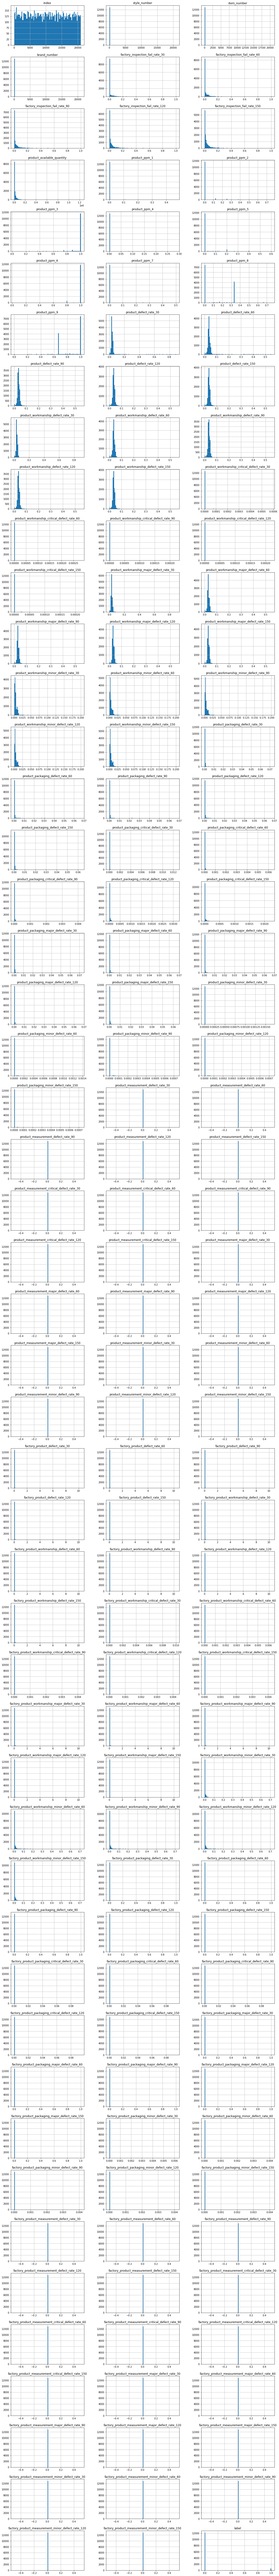

In [8]:

filteredColumns = raw_df.dtypes[raw_df.dtypes != object] #filter not object type
listOfColumnNames = list(filteredColumns.index)


fig, axes = plt.subplots(len(listOfColumnNames)//3, 3, figsize=(20, 200))

i = 0
for triaxis in axes:
    for axis in triaxis:
        raw_df.hist(column = listOfColumnNames[i], bins = 100, ax=axis)
        i = i+1


### Handling categorical data

In [9]:
# Get a Dictionary containing the pairs of column names & data type objects.
object_columns = raw_df.dtypes[raw_df.dtypes == object]
# list of columns whose data type is object i.e. string
list_object_columns = list(object_columns.index)
print(list_object_columns)

['hashed_factory_id', 'country', 'hashed_type_of_inspection', 'hashed_product_line', 'hashed_product_category', 'hashed_product_id']


In [10]:
raw_df = pd.get_dummies(raw_df, columns=list_object_columns, \
               prefix=["factory", "country", "type_inspect", "product_line", "product_category", "product_id"])

In [11]:
raw_df

,index,style_number,item_number,brand_number,factory_inspection_fail_rate_30,factory_inspection_fail_rate_60,factory_inspection_fail_rate_90,factory_inspection_fail_rate_120,factory_inspection_fail_rate_150,product_available_quantity,...,product_id_f32f6c37783a220c644f44b91ac4aee9ac2484cd,product_id_f47d7542601eaeafa33f686f3694aa5f30974725,product_id_f4cef06fe71f6c27ed7c53ccb88afe3da61d6d13,product_id_f87454547cc54d1c620cbeccfc099019f69f1992,product_id_f8858d8972e782ce210854d06969f72bb988875a,product_id_fa7882c215414f5df52a72b230012dfc09170efb,product_id_fadb034a6b19f2e334b911e6b1c77d4768cfc3dc,product_id_fc032818bd7d471b9ba56bfb076b044a6fbf9ec8,product_id_fc372290cf9fded451fe6dedee10da7d28ee5ff7,product_id_fd9b45f5cf1164b2b0a3b955588aa4551dd07c47
0,7,1,8,1.0,0.000000,0.032258,0.028571,0.027778,0.025641,2082.0,...,0,0,0,0,0,0,0,0,0,0
1,8,1,5,1.0,0.000000,0.200000,0.035714,0.020408,0.018182,12948.0,...,0,0,0,0,0,0,0,0,0,0
3,10,2,12,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,828.0,...,0,0,0,0,0,0,0,0,0,0
4,11,1,2,1.0,0.000000,0.000000,0.000000,0.100000,0.083333,2016.0,...,0,0,0,0,0,0,0,0,0,0
5,13,1,12,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,144.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,20966,1,15,1.0,0.000000,0.000000,0.022222,0.021277,0.020408,7548.0,...,0,0,0,0,0,0,0,0,0,0
13289,20967,1,18,1.0,0.015385,0.009174,0.012195,0.010870,0.024631,4056.0,...,0,0,0,0,0,0,0,0,0,0
13290,20970,3,20,1.0,0.071429,0.053571,0.045977,0.039604,0.039216,17790.0,...,0,0,0,0,0,0,0,0,0,1
13291,20974,9,33,1.0,0.000000,0.000000,0.023529,0.018868,0.018868,684.0,...,0,0,0,0,0,0,0,0,0,0


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [12]:
neg, pos = np.bincount(raw_df['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 12847
    Positive: 633 (4.93% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Index` and `style_number`, `item_number`, `brand_number`, `product_available_quantity` columns. Drop the `Index` column (since it's not clear what it means) and take the log of the `style_number`, `item_number`, `brand_number`, `product_available_quantity` column to reduce its range.

In [13]:
cleaned_df = raw_df.copy()

# You don't want the `Index` column.
cleaned_df.pop('index')

# The `style_number`, 'item_number', 'brand_number', 'product_available_quantity' column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log style_number'] = np.log(cleaned_df.pop('style_number')+eps)
cleaned_df['Log item_number'] = np.log(cleaned_df.pop('item_number')+eps)
cleaned_df['Log brand_number'] = np.log(cleaned_df.pop('brand_number')+eps)
cleaned_df['Log product_available_quantity'] = np.log(cleaned_df.pop('product_available_quantity')+eps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


['Log style_number', 'Log item_number', 'Log brand_number', 'Log product_available_quantity']


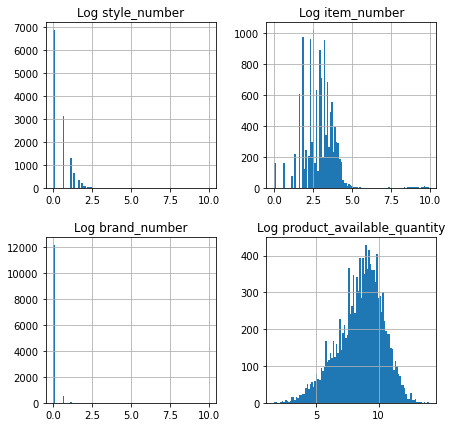

In [14]:
# Visualize the distribution of above feature
listOfColumnNames = ['Log style_number', 'Log item_number', 'Log brand_number', 'Log product_available_quantity']
print(listOfColumnNames)


fig, axes = plt.subplots(len(listOfColumnNames)//2, 2, figsize=(7, 7))

i = 0
for triaxis in axes:
    for axis in triaxis:
        cleaned_df.hist(column = listOfColumnNames[i], bins = 100, ax=axis)
        i = i+1


Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [15]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('label'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('label'))
test_labels = np.array(test_df.pop('label'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.


In [16]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (8221,)
Validation labels shape: (2056,)
Test labels shape: (2570,)
Training features shape: (8221, 939)
Validation features shape: (2056, 939)
Test features shape: (2570, 939)


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features.

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.

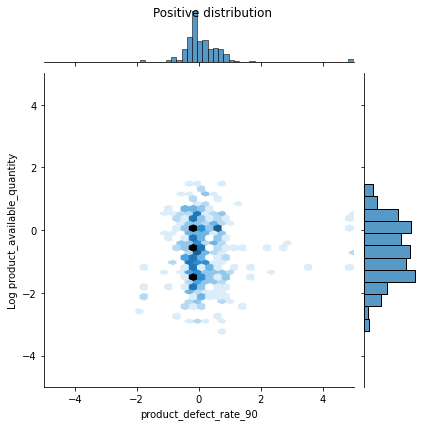

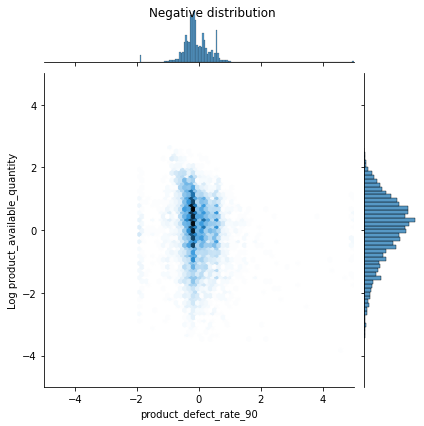

In [17]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['product_defect_rate_90'], y=pos_df['Log product_available_quantity'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['product_defect_rate_90'], y=neg_df['Log product_available_quantity'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no high risk product to learn from.


Note: this model will not handle the class imbalance well. We will improve it later in this tutorial.

In [19]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [20]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                15040     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 15,057
Trainable params: 15,057
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [21]:
model.predict(train_features[:10])

array([[0.83110595],
       [0.76833045],
       [0.7634292 ],
       [0.71509516],
       [0.83142567],
       [0.7240169 ],
       [0.7388805 ],
       [0.79005873],
       [0.69984066],
       [0.71090245]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [22]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.4068


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [23]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.95986769])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

In [24]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.03270748],
       [0.05303624],
       [0.04399738],
       [0.05331179],
       [0.03286761],
       [0.04925719],
       [0.06786472],
       [0.0547767 ],
       [0.02423444],
       [0.02287373]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0)$$

In [25]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.1996


This initial loss is about 6 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [26]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [27]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [28]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [29]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

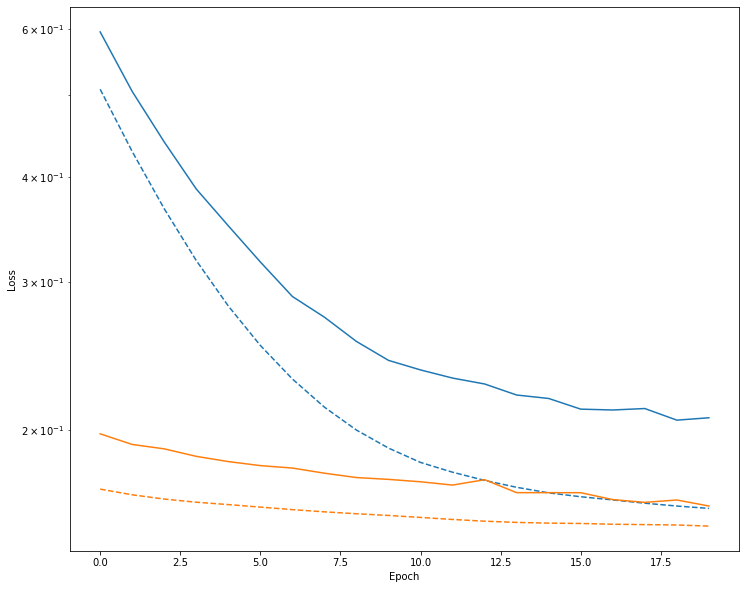

In [30]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [31]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
5/5 [==============================] - 3s 277ms/step - loss: 0.2025 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 9782.0000 - fn: 495.0000 - accuracy: 0.9518 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5670 - prc: 0.0734 - val_loss: 0.1702 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1971.0000 - val_fn: 85.0000 - val_accuracy: 0.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5778 - val_prc: 0.0827
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 0.1938 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7811.0000 - fn: 410.0000 - accuracy: 0.9501 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6214 - prc: 0.0861 - val_loss: 0.1676 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1971.0000 - val_fn: 85.0000 - val_accuracy: 0.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6251 - val_prc: 0.1100
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 0.1896 - tp: 1.0000 - fp: 1.0000 

### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [32]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

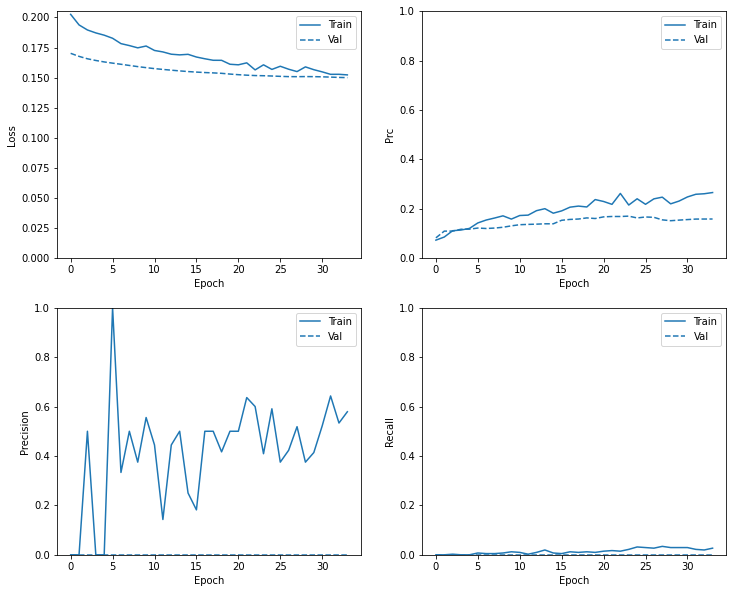

In [33]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

We use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [34]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [35]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Low Risk Detected (True Negatives): ', cm[0][0])
  print('High Risk Incorrectly Detected (False Positives): ', cm[0][1])
  print('Low Risk Missed (False Negatives): ', cm[1][0])
  print('High Risk Detected (True Positives): ', cm[1][1])
  print('Total Risk product: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.1804836392402649
tp :  0.0
fp :  0.0
tn :  2432.0
fn :  138.0
accuracy :  0.9463034868240356
precision :  0.0
recall :  0.0
auc :  0.7981666326522827
prc :  0.1751747578382492

Low Risk Detected (True Negatives):  2432
High Risk Incorrectly Detected (False Positives):  0
Low Risk Missed (False Negatives):  138
High Risk Detected (True Positives):  0
Total Risk product:  138


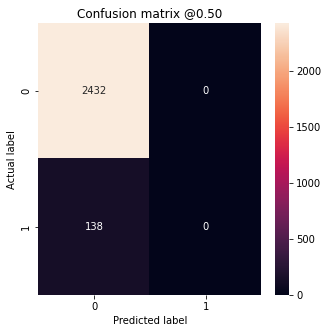

In [36]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few low risk that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. 

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [37]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100])

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

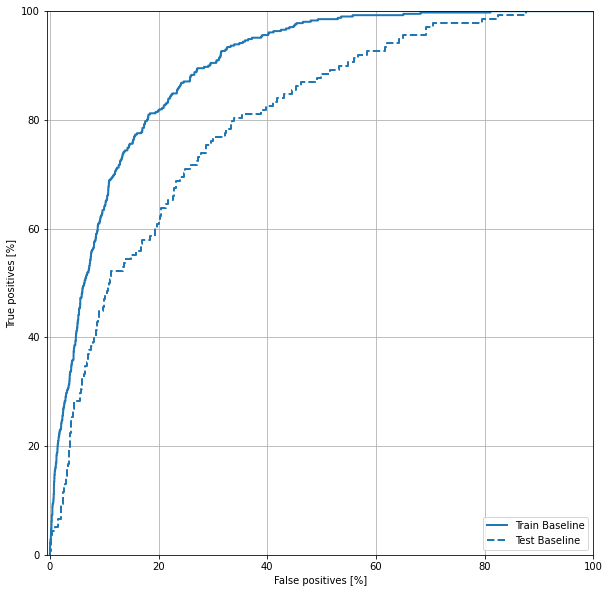

In [38]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [39]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

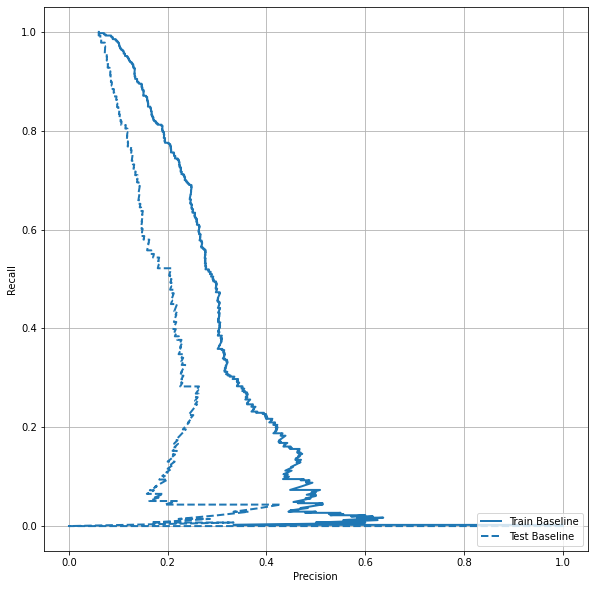

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about.

## Class weights

### Calculate class weights

The goal is to identify risk product, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [41]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 10.15


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [42]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
5/5 [==============================] - 3s 273ms/step - loss: 1.6072 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10243.0000 - fn: 548.0000 - accuracy: 0.9492 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6099 - prc: 0.0948 - val_loss: 0.1714 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1971.0000 - val_fn: 85.0000 - val_accuracy: 0.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5713 - val_prc: 0.0816
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 1.4589 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7811.0000 - fn: 410.0000 - accuracy: 0.9501 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6030 - prc: 0.0762 - val_loss: 0.1714 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1971.0000 - val_fn: 85.0000 - val_accuracy: 0.9587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6161 - val_prc: 0.0979
Epoch 3/100
5/5 [==============================] - 0s 22ms/step - loss: 1.3471 - tp: 0.0000e+00 - fp: 0.

### Check training history

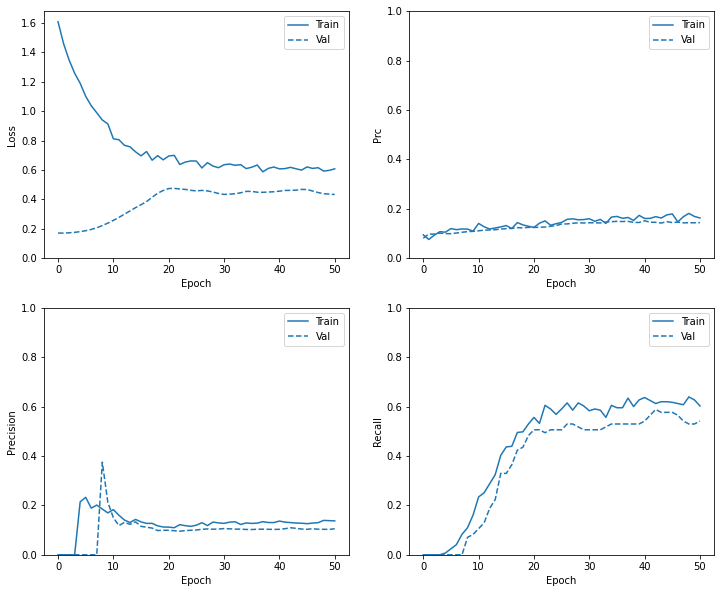

In [43]:
plot_metrics(weighted_history)

### Evaluate metrics

In [44]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.44083550572395325
tp :  84.0
fp :  449.0
tn :  1983.0
fn :  54.0
accuracy :  0.804280161857605
precision :  0.15759849548339844
recall :  0.6086956262588501
auc :  0.7919855117797852
prc :  0.1812797635793686

Low Risk Detected (True Negatives):  1983
High Risk Incorrectly Detected (False Positives):  449
Low Risk Missed (False Negatives):  54
High Risk Detected (True Positives):  84
Total Risk product:  138


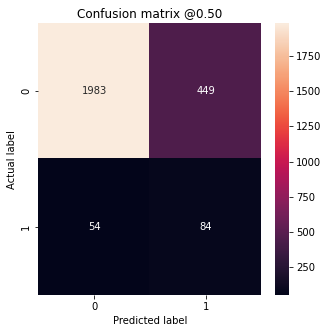

In [45]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more high risk product).

### Plot the ROC

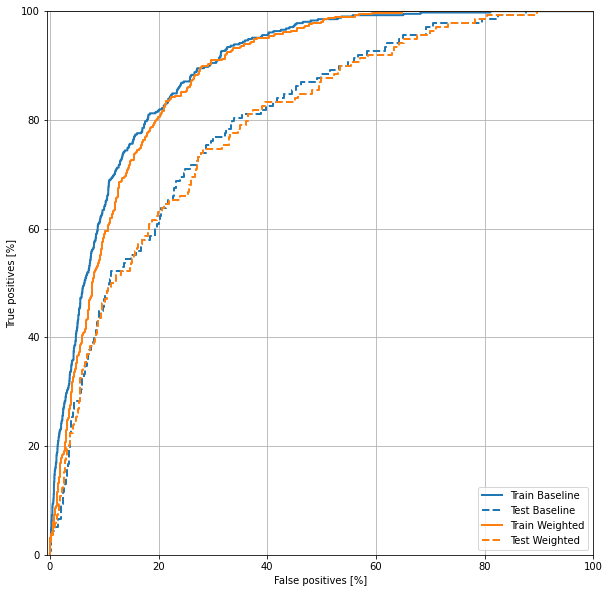

In [46]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the AUPRC

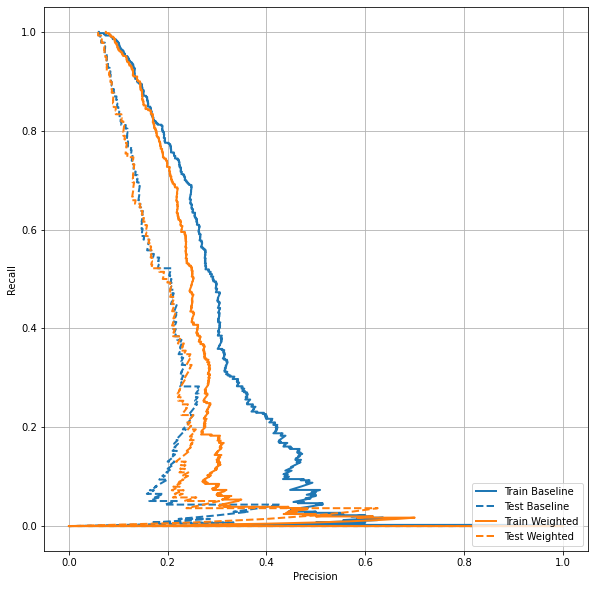

In [47]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [48]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [49]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(7811, 939)

In [50]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(15622, 939)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [51]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [52]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.35459631 -0.41953724 -0.48238807 -0.53224634 -0.58139505 -0.07315489
  1.51024613 -1.25738815 -0.0416365   3.10414406 -2.71375659 -0.08838435
  1.2436312  -1.17648139 -0.09060519 -0.16159002 -0.16967292 -0.17429705
 -0.17925368 -0.07875156 -0.14675805 -0.15237616 -0.15662365 -0.16136466
 -0.11315911 -0.12849958 -0.1291689  -0.12794283 -0.12787388 -0.31981939
 -0.44869207 -0.49320227 -0.49948897 -0.50470293  1.53587251  1.41163805
  1.42750322  1.43076437  1.43174606 -0.14167696 -0.16569523 -0.17723125
 -0.18096593 -0.18507925 -0.15152338 -0.15914548 -0.16922615 -0.17043157
 -0.19601482 -0.13517796 -0.15701816 -0.16797616 -0.16990355 -0.17327202
 -0.07446728 -0.10603251 -0.12790426 -0.13211014 -0.13334288  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.24970417 -0.25310387 -0.25352573 -0.25378994 -0.25488831

Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [53]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [54]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.509765625


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [55]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

12.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [56]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
12/12 [==============================] - 4s 181ms/step - loss: 0.6668 - tp: 7093.0000 - fp: 4969.0000 - tn: 9636.0000 - fn: 5448.0000 - accuracy: 0.6163 - precision: 0.5880 - recall: 0.5656 - auc: 0.6621 - prc: 0.6035 - val_loss: 0.6608 - val_tp: 53.0000 - val_fp: 760.0000 - val_tn: 1211.0000 - val_fn: 32.0000 - val_accuracy: 0.6148 - val_precision: 0.0652 - val_recall: 0.6235 - val_auc: 0.6713 - val_prc: 0.1039
Epoch 2/100
12/12 [==============================] - 1s 82ms/step - loss: 0.5952 - tp: 9418.0000 - fp: 4539.0000 - tn: 7693.0000 - fn: 2926.0000 - accuracy: 0.6962 - precision: 0.6748 - recall: 0.7630 - auc: 0.7635 - prc: 0.7404 - val_loss: 0.6101 - val_tp: 55.0000 - val_fp: 623.0000 - val_tn: 1348.0000 - val_fn: 30.0000 - val_accuracy: 0.6824 - val_precision: 0.0811 - val_recall: 0.6471 - val_auc: 0.7145 - val_prc: 0.1157
Epoch 3/100
12/12 [==============================] - 1s 83ms/step - loss: 0.5496 - tp: 9626.0000 - fp: 3577.0000 - tn: 8578.0000 - fn: 2795.0000 

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

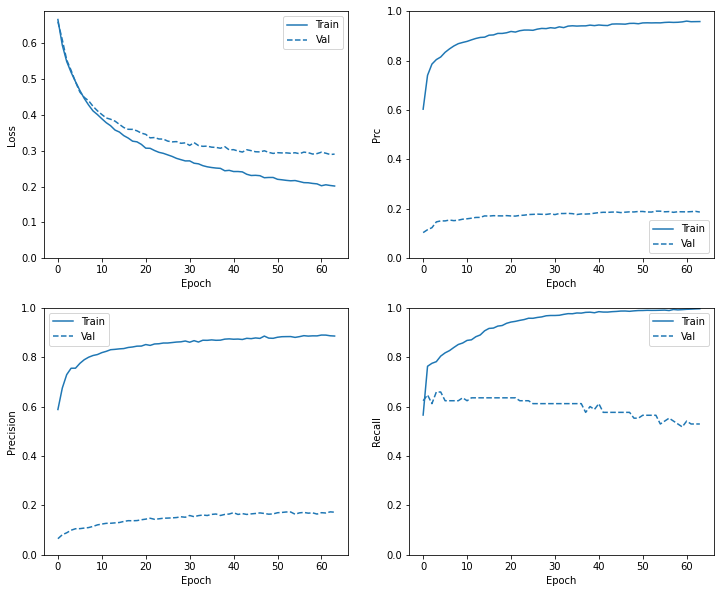

In [57]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [58]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 5s 158ms/step - loss: 0.6418 - tp: 13091.0000 - fp: 7923.0000 - tn: 14596.0000 - fn: 7406.0000 - accuracy: 0.6436 - precision: 0.6230 - recall: 0.6387 - auc: 0.7002 - prc: 0.6608 - val_loss: 0.6220 - val_tp: 53.0000 - val_fp: 654.0000 - val_tn: 1317.0000 - val_fn: 32.0000 - val_accuracy: 0.6663 - val_precision: 0.0750 - val_recall: 0.6235 - val_auc: 0.7071 - val_prc: 0.1099
Epoch 2/1000
20/20 [==============================] - 2s 83ms/step - loss: 0.5549 - tp: 15293.0000 - fp: 5818.0000 - tn: 14817.0000 - fn: 5032.0000 - accuracy: 0.7351 - precision: 0.7244 - recall: 0.7524 - auc: 0.8058 - prc: 0.7710 - val_loss: 0.5256 - val_tp: 53.0000 - val_fp: 495.0000 - val_tn: 1476.0000 - val_fn: 32.0000 - val_accuracy: 0.7437 - val_precision: 0.0967 - val_recall: 0.6235 - val_auc: 0.7423 - val_prc: 0.1267
Epoch 3/1000
20/20 [==============================] - 2s 85ms/step - loss: 0.5007 - tp: 16075.0000 - fp: 5030.0000 - tn: 15486.0000 - fn: 4

### Re-check training history

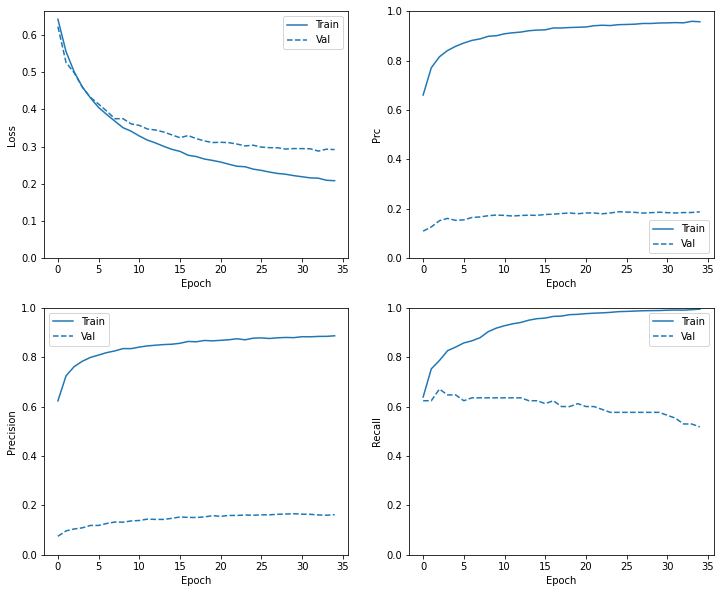

In [59]:
plot_metrics(resampled_history)

### Evaluate metrics

In [60]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.31783241033554077
tp :  73.0
fp :  307.0
tn :  2125.0
fn :  65.0
accuracy :  0.8552529215812683
precision :  0.1921052634716034
recall :  0.5289855003356934
auc :  0.8042316436767578
prc :  0.19606533646583557

Low Risk Detected (True Negatives):  2125
High Risk Incorrectly Detected (False Positives):  307
Low Risk Missed (False Negatives):  65
High Risk Detected (True Positives):  73
Total Risk product:  138


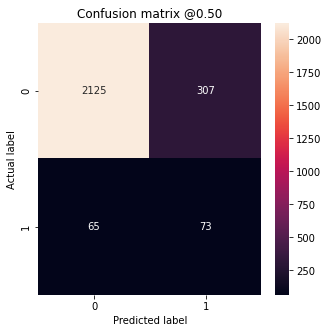

In [61]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

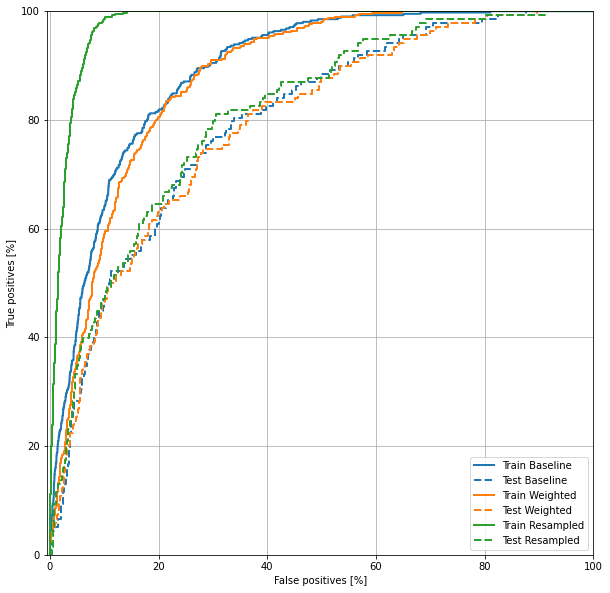

In [62]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


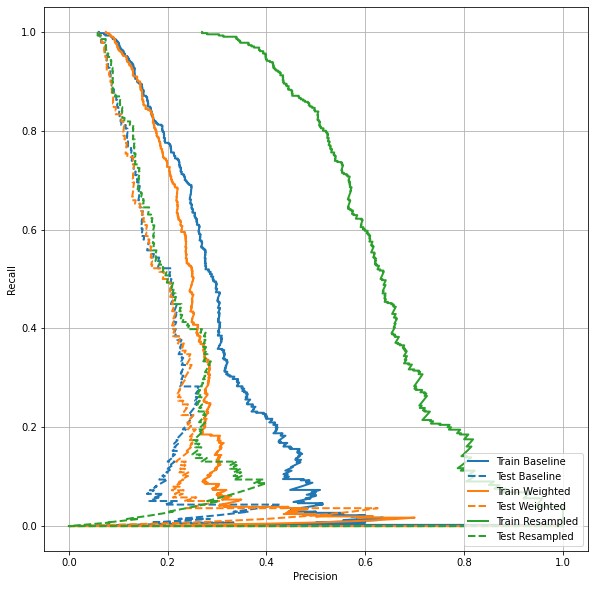

In [63]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Conclusion

This problem is an inherently difficult task since there are so few samples to learn from. We should always start with the data first and do our best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point the model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.